In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [41]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [42]:
initializer = initializers.RandomUniform(minval=-1.0, maxval=1.0)

class regressor(Model):
    def __init__(self):
        super(regressor, self).__init__()
        self.reg = tf.keras.Sequential([
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(1, activation='sigmoid',kernel_initializer=initializer)
        ])

    def call(self, x):
        y = self.reg(x)
        return y

In [43]:
dataset = pd.read_csv('encoded_dataset.csv',usecols=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','heat_of_formation'])
dataset.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,heat_of_formation
0,-0.944244,-0.467843,-0.250634,-0.607917,0.722437,2.718357,1.390860,0.095709,-0.376503,-0.381374,-1.240558
1,-0.184422,-0.263323,-0.406619,1.421094,1.284893,3.853995,1.308007,-0.123640,1.368393,0.935994,-1.012833
2,-0.381459,-0.321316,-0.360481,0.190600,1.159082,3.447642,1.226776,-0.085541,0.499673,0.133785,-1.145090
3,-0.791677,-0.419213,-0.270855,-0.446005,0.817097,2.801007,1.504990,-0.020920,-0.254898,-0.273302,-1.112540
4,-0.785569,-0.452266,-0.316529,-0.389248,0.983658,3.238737,0.938708,0.085265,-0.219014,-0.267498,-1.162859


In [44]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(432, 10) (108, 10) (432,) (108,)


In [46]:
sc_x = StandardScaler()
sc_x.fit(X_train)
X_train_sc = sc_x.transform(X_train)
X_test_sc = sc_x.transform(X_test)
ms_y = MinMaxScaler(feature_range=(0,1))
ms_y.fit(y_train.reshape(y_train.shape[0],-1))
y_train_sc = ms_y.transform(y_train.reshape(y_train.shape[0],-1))
y_test_sc = ms_y.transform(y_test.reshape(y_test.shape[0],-1))

In [47]:
def scheduler(epoch, lr):
    if epoch<25:
        return lr
    elif epoch >=25 and epoch < 50:
        return lr*0.99
    elif epoch >=50 and epoch <75:
        return lr*0.98
    else:
        return lr*0.80


In [48]:
lr_scheduler = LearningRateScheduler(
    scheduler,
    verbose=0
)

In [49]:
rlr = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    factor=0.85
)

In [50]:
model = regressor()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss='mean_squared_error')

In [51]:
history = model.fit(X_train_sc, y_train_sc,validation_split=0.2, epochs=200, batch_size=5, verbose=0, shuffle=True, callbacks=[rlr,lr_scheduler])

In [52]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss', color='red')
    plt.plot(history.history['val_loss'], label='val_loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

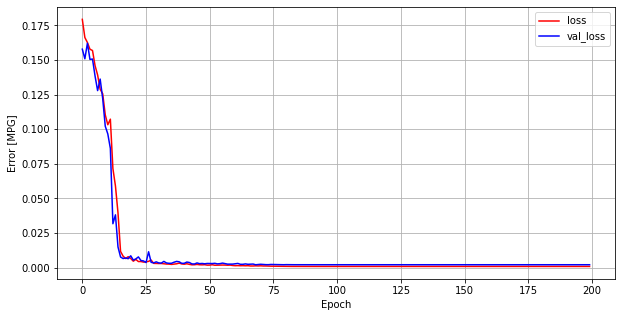

In [53]:
plot_loss(history)

### Testing the model

In [54]:
y_true = y_test_sc.reshape(-1,y_test_sc.shape[0])
y_pred = model.predict(X_test_sc)
y_pred = y_pred.reshape(-1,y_pred.shape[0])

In [55]:
mse = tf.keras.losses.MeanSquaredError()
error = mse(y_pred, y_true).numpy()
print(f'Test Error of model : {error*100:.2f} %')

Test Error of model : 0.15 %


In [56]:
unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
R_squared = tf.subtract(1, tf.divide(unexplained_error, total_error))
print(f'r2 score of the model : {R_squared.numpy():.4f}')

r2 score of the model : 0.9705


### Plot of Predicted heat of formation vs True heat of formation

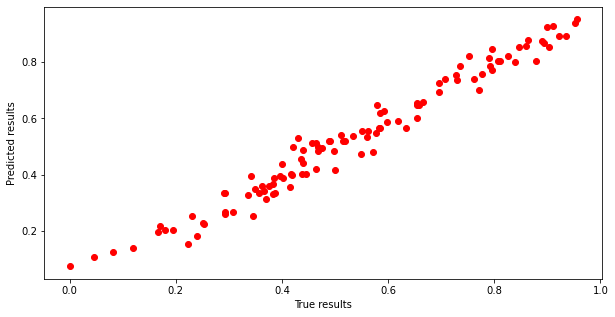

In [57]:
plt.figure(figsize=(10,5))
plt.scatter(y_true, y_pred, color='red')
plt.xlabel('True results')
plt.ylabel('Predicted results')
plt.show()

### Model Architecture Visualization

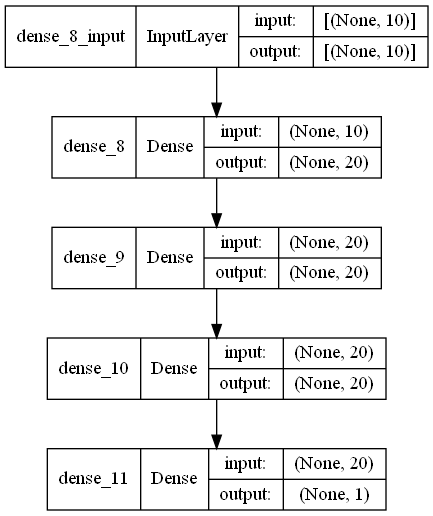

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model.reg, to_file='model.png',show_shapes=True)